In [1]:
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import pandas_ta as pta
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
import ta
import pandas as pd

In [2]:
class AdxSmaCciStrategy(Strategy):
    def __init__(self, params: dict):
        super().__init__()
        self.cci_length = params.get('cci_length', 72)
        self.cci_threshold = params.get('cci_threshold', 120)
        self.sma_length_short = params.get('sma_length_short', 6)
        self.sma_length_long = params.get('sma_length_long', 72)
        self.adx_length = params.get('adx_length', 24)
        self.adx_threshold = params.get('adx_threshold', 40)
        self.trail_percentage = params.get('trail_percentage', 0.05)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.1)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate CCI
        data['cci'] = pta.cci(data['high'], data['low'], data['close'], length=self.cci_length)

        # Calculate SMA
        data['sma_short'] = pta.sma(data['close'], length=self.sma_length_short)
        data['sma_long'] = pta.sma(data['close'], length=self.sma_length_long)

        # Calculate ADX
        adx = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length)
        data['adx'] = adx['ADX_' + str(self.adx_length)]

        # Define signals
        data['cci_bullish'] = data['cci'] < self.cci_threshold
        data['sma_buy'] = (data['sma_short'] > data['sma_long']) & (data['close'] > data['sma_short'])
        data['strong_trend'] = data['adx'] > self.adx_threshold

        # Combine signals
        data['long_entry'] = (
            data['sma_buy']
            & data['cci_bullish']
            & data['strong_trend']
        )

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)


In [3]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

def detect_deep_v_shapes(curve_series, order):
    periods = (order // 2) - 1
    depth_threshold = curve_series.diff(periods=periods).abs().mean()
    slope_threshold = 0

    # Find local minima
    minima = argrelextrema(curve_series.values, np.less, order=order)[0]

    # Initialize v_shapes series with False
    v_shapes = pd.Series(False, index=curve_series.index)
    
    for idx in minima:
        if idx - order < 0 or idx + order >= len(curve_series):
            continue
        
        # Calculate left and right slopes
        left_slope = (curve_series.iloc[idx] - curve_series.iloc[idx - order]) / order
        right_slope = (curve_series.iloc[idx + order] - curve_series.iloc[idx]) / order
        
        # Check if it forms a V shape
        if left_slope < -slope_threshold and right_slope > slope_threshold:
            # Calculate depth
            depth = min(curve_series.iloc[idx - order] - curve_series.iloc[idx],
                        curve_series.iloc[idx + order] - curve_series.iloc[idx])
            
            if depth > depth_threshold:
                # Mark the V shape at its end (idx + order) instead of the lowest point
                v_shapes.iloc[idx + order] = True
    
    return v_shapes

def is_local_minima(series, lookback=3):
    series_diff = series.diff(periods=1)

    # Ensure the lookback value is appropriate for the calculation
    if lookback < 2:
        raise ValueError("Lookback must be at least 2.")

    # Calculate the midpoint for splitting the lookback period
    midpoint = lookback // 2  # Integer division to ensure midpoint is an integer

    # Calculate the average difference
    average_drop = series_diff[series_diff < 0].mean()
    average_rise = series_diff[series_diff > 0].mean()

    # Conditions for detecting a local minima
    # The first half should be decreasing (negative difference)
    conditions = [(series_diff.shift(i) < 0) for i in range(lookback-1, midpoint-1, -1)]

    # The second half should be increasing (positive difference)
    conditions.extend([(series_diff.shift(i) > 0) for i in range(midpoint-1, -1, -1)])

    # Check if all conditions are met
    return pd.concat(conditions, axis=1).all(axis=1)

In [4]:
class AdxEmaRsiStrategy(Strategy):
    def __init__(self, params=None):
        super().__init__()
        self.adx_length = params.get('adx_length', 12)
        self.adx_threshold = params.get('adx_threshold', 30)
        self.ema_length_very_short = params.get('ema_length_very_short', 6)
        self.ema_length_short = params.get('ema_length_short', 12)
        self.ema_length_long = params.get('ema_length_long', 72)
        self.rsi_length = params.get('rsi_length', 48)
        self.rsi_oversold = params.get('rsi_oversold', 20)
        self.trail_percentage = params.get('trail_percentage', 0.05)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.05)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate ADX
        adx = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length)
        data['adx'] = adx['ADX_' + str(self.adx_length)]

        # Calculate SMA
        data['ema_very_short'] = pta.ema(data['close'], length=self.ema_length_very_short)
        data['ema_short'] = pta.ema(data['close'], length=self.ema_length_short)
        data['ema_long'] = pta.ema(data['close'], length=self.ema_length_long) 

        # Calculate RSI
        data['rsi'] = pta.rsi(data['ema_long'], length=self.rsi_length)

        # Define signals
        data['strong_trend'] = (data['adx'] > self.adx_threshold)
        data['rsi_oversold'] = data['rsi'] < self.rsi_oversold
        data['ema_buy'] = (data['ema_short'] > data['ema_long']) & (data['ema_very_short'] > data['ema_short']) & (data['close'] > data['ema_short'])
        data['ema_sell'] = (data['ema_very_short'] < data['ema_short'])

        # Combine all conditions for long entry
        data['long_entry'] = (
            data['strong_trend'] &
            data['rsi_oversold'] &
            data['ema_buy'] 
        )
        data['long_exit'] = (data['ema_sell'])

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            if not portfolio.is_long(symbol):
                if self.trail_percentage and self.take_profit_percentage:
                    portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)
                else:
                    portfolio.open_long(symbol, 1)
        elif last_price_point['long_exit'] and not self.trail_percentage and not self.take_profit_percentage:
            if portfolio.is_long(symbol):
                portfolio.close_long(symbol)


In [5]:
class AdxEmaStrategy(Strategy):
    def __init__(self, params=None):
        super().__init__()
        self.adx_length = params.get('adx_length', 24)
        self.adx_threshold = params.get('adx_threshold', 30)
        self.ema_length_short = params.get('ema_length_short', 24)
        self.ema_length_long = params.get('ema_length_long', 168)
        self.trail_percentage = params.get('trail_percentage', 0.05)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.1)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate ADX
        adx = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length)
        data['adx'] = adx['ADX_' + str(self.adx_length)]

        # Calculate EMA
        data['ema_short'] = pta.ema(data['close'], length=self.ema_length_short)
        data['ema_long'] = pta.ema(data['close'], length=self.ema_length_long)

        # Define signals
        data['strong_trend'] = (data['adx'] > self.adx_threshold)
        data['ema_buy'] = (data['ema_short'] > data['ema_long']) & (data['close'] > data['ema_short'])
        data['ema_sell'] = (data['ema_short'] < data['ema_long'])

        # Combine all conditions for long entry
        data['long_entry'] = (data['strong_trend'] & data['ema_buy'])
        data['long_exit'] = (data['ema_sell'])

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            if not portfolio.is_long(symbol):
                portfolio.open_long(symbol, 1)
        elif last_price_point['long_exit']:
            if portfolio.is_long(symbol):
                portfolio.close_long(symbol)


In [6]:
class SmaBuyDipStrategy(Strategy):
    def __init__(self, params=None):
        super().__init__()
        self.sma_length_long = params.get('sma_length_long', 72)
        self.drop_period = params.get('drop_period', 12)
        self.recovery_period = params.get('recovery_period', 6)
        self.drop_threshold = params.get('drop_threshold', 2)
        self.recovery_threshold = params.get('recovery_threshold', 2)
        self.rsi_length = params.get('rsi_length', 14)
        self.rsi_not_overbought = params.get('rsi_not_overbought', 70)
        self.trail_percentage = params.get('trail_percentage', 0.05)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.1)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate SMA long
        data['sma_long'] = pta.sma(data['close'], length=self.sma_length_long)

        # Calculate drop and recovery
        data['sma_long_drop'] = data['sma_long'].pct_change(periods=self.drop_period)
        average_drop = data['sma_long_drop'].mean()
        data['sma_long_recovery'] = data['sma_long'].pct_change(periods=self.recovery_period)
        average_recovery = data['sma_long_recovery'].mean()

        # Calculate RSI
        data['rsi'] = pta.rsi(data['close'], length=self.rsi_length)

        # Define buy dip signal with RSI filter
        data['long_entry'] = (data['sma_long_drop'].shift(self.recovery_period) < -self.drop_threshold * abs(average_drop)) & \
                              (data['sma_long_recovery'] > self.recovery_threshold * abs(average_recovery)) & \
                              (data['rsi'] < self.rsi_not_overbought)

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)



In [7]:
import os
import csv

# CSV file path
csv_file = f'performance_tests.csv'

# Define the header
header = [
    'strategy', 'symbol', 'invert_pair', 'start_date', 'end_date', 'frequency', 'cci_length', 'cci_threshold',
    'adx_length', 'adx_threshold', 'rsi_length', 'rsi_oversold', 'rsi_not_overbought', 'ema_length_very_short', 'ema_length_short',
    'ema_length_long', 'sma_length_very_short', 'sma_length_short', 'sma_length_long', 'supertrend_length', 'supertrend_multiplier', 
    'drop_period', 'recovery_period', 'drop_threshold', 'recovery_threshold', 'trail_percentage', 'take_profit_percentage', 
    'win_rate', 'portfolio_return', 'asset_return', 'portfolio_max_drawdown', 'asset_max_drawdown', 'portfolio_id'
]

def write_to_csv(strategy, symbol, reverse_pair, start_date, end_date, frequency, strategy_params, perf, portfolio):

    # Check if the file exists and is empty
    file_exists = os.path.isfile(csv_file)
    file_empty = file_exists and os.path.getsize(csv_file) == 0

    # Open the file in append mode
    with open(csv_file, 'a', newline='') as f:
        writer = csv.writer(f)
        
        # Write header if file is empty or doesn't exist
        if not file_exists or file_empty:
            writer.writerow(header)
        
        # Write the data
        writer.writerow([
            strategy.__class__.__name__,
            symbol,
            reverse_pair,
            start_date.strftime('%Y-%m-%d'),
            end_date.strftime('%Y-%m-%d'),
            frequency,
            strategy_params.get('cci_length', ''),
            strategy_params.get('cci_threshold', ''),
            strategy_params.get('adx_length', ''),
            strategy_params.get('adx_threshold', ''),
            strategy_params.get('rsi_length', ''),
            strategy_params.get('rsi_oversold', ''),
            strategy_params.get('rsi_not_overbought', ''),
            strategy_params.get('ema_length_very_short', ''),
            strategy_params.get('ema_length_short', ''),
            strategy_params.get('ema_length_long', ''),
            strategy_params.get('sma_length_very_short', ''),
            strategy_params.get('sma_length_short', ''),
            strategy_params.get('sma_length_long', ''),
            strategy_params.get('supertrend_length', ''),
            strategy_params.get('supertrend_multiplier', ''),
            strategy_params.get('drop_period', ''),
            strategy_params.get('recovery_period', ''),
            strategy_params.get('drop_threshold', ''),
            strategy_params.get('recovery_threshold', ''),
            strategy_params.get('trail_percentage', ''),
            strategy_params.get('take_profit_percentage', ''),
            perf['win_rate'],
            perf['portfolio_return'],
            perf['asset_return'],
            perf['portfolio_max_drawdown'],
            perf['asset_max_drawdown'],
            portfolio.uuid
        ])

Request to open long position on ETH-GBP
    Opening long position for ETH-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for ETH-GBP at 1189.207275390625 with quantity 0.837532716634986, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for ETH-GBP at 1189.207275390625 with quantity 0.837532716634986, total cost £999.984 and transaction cost £3.984
        Bought 0.837532716634986 ETH-GBP at 1189.207275390625 on 14/10/2022 12:00
    Creating TRAILING_STOP SELL order for ETH-GBP at 1189.207275390625 with quantity 0.837532716634986, trail 0.05, limit None, stop None, take_profit None
    Updated trailing stop to 1130.2282348632812
    Updated trailing stop to 1145.3179565429687
    Creating TRAILING_STOP SELL order for ETH-GBP at 1204.7783203125 with quantity 0.837532716634986, trail 0.04095874044573666, limit None, stop None, take_profit None
Updated trailing stop for ETH-GBP to 1155.43 (trail: 4.10%)
    Updated trailing stop to 11

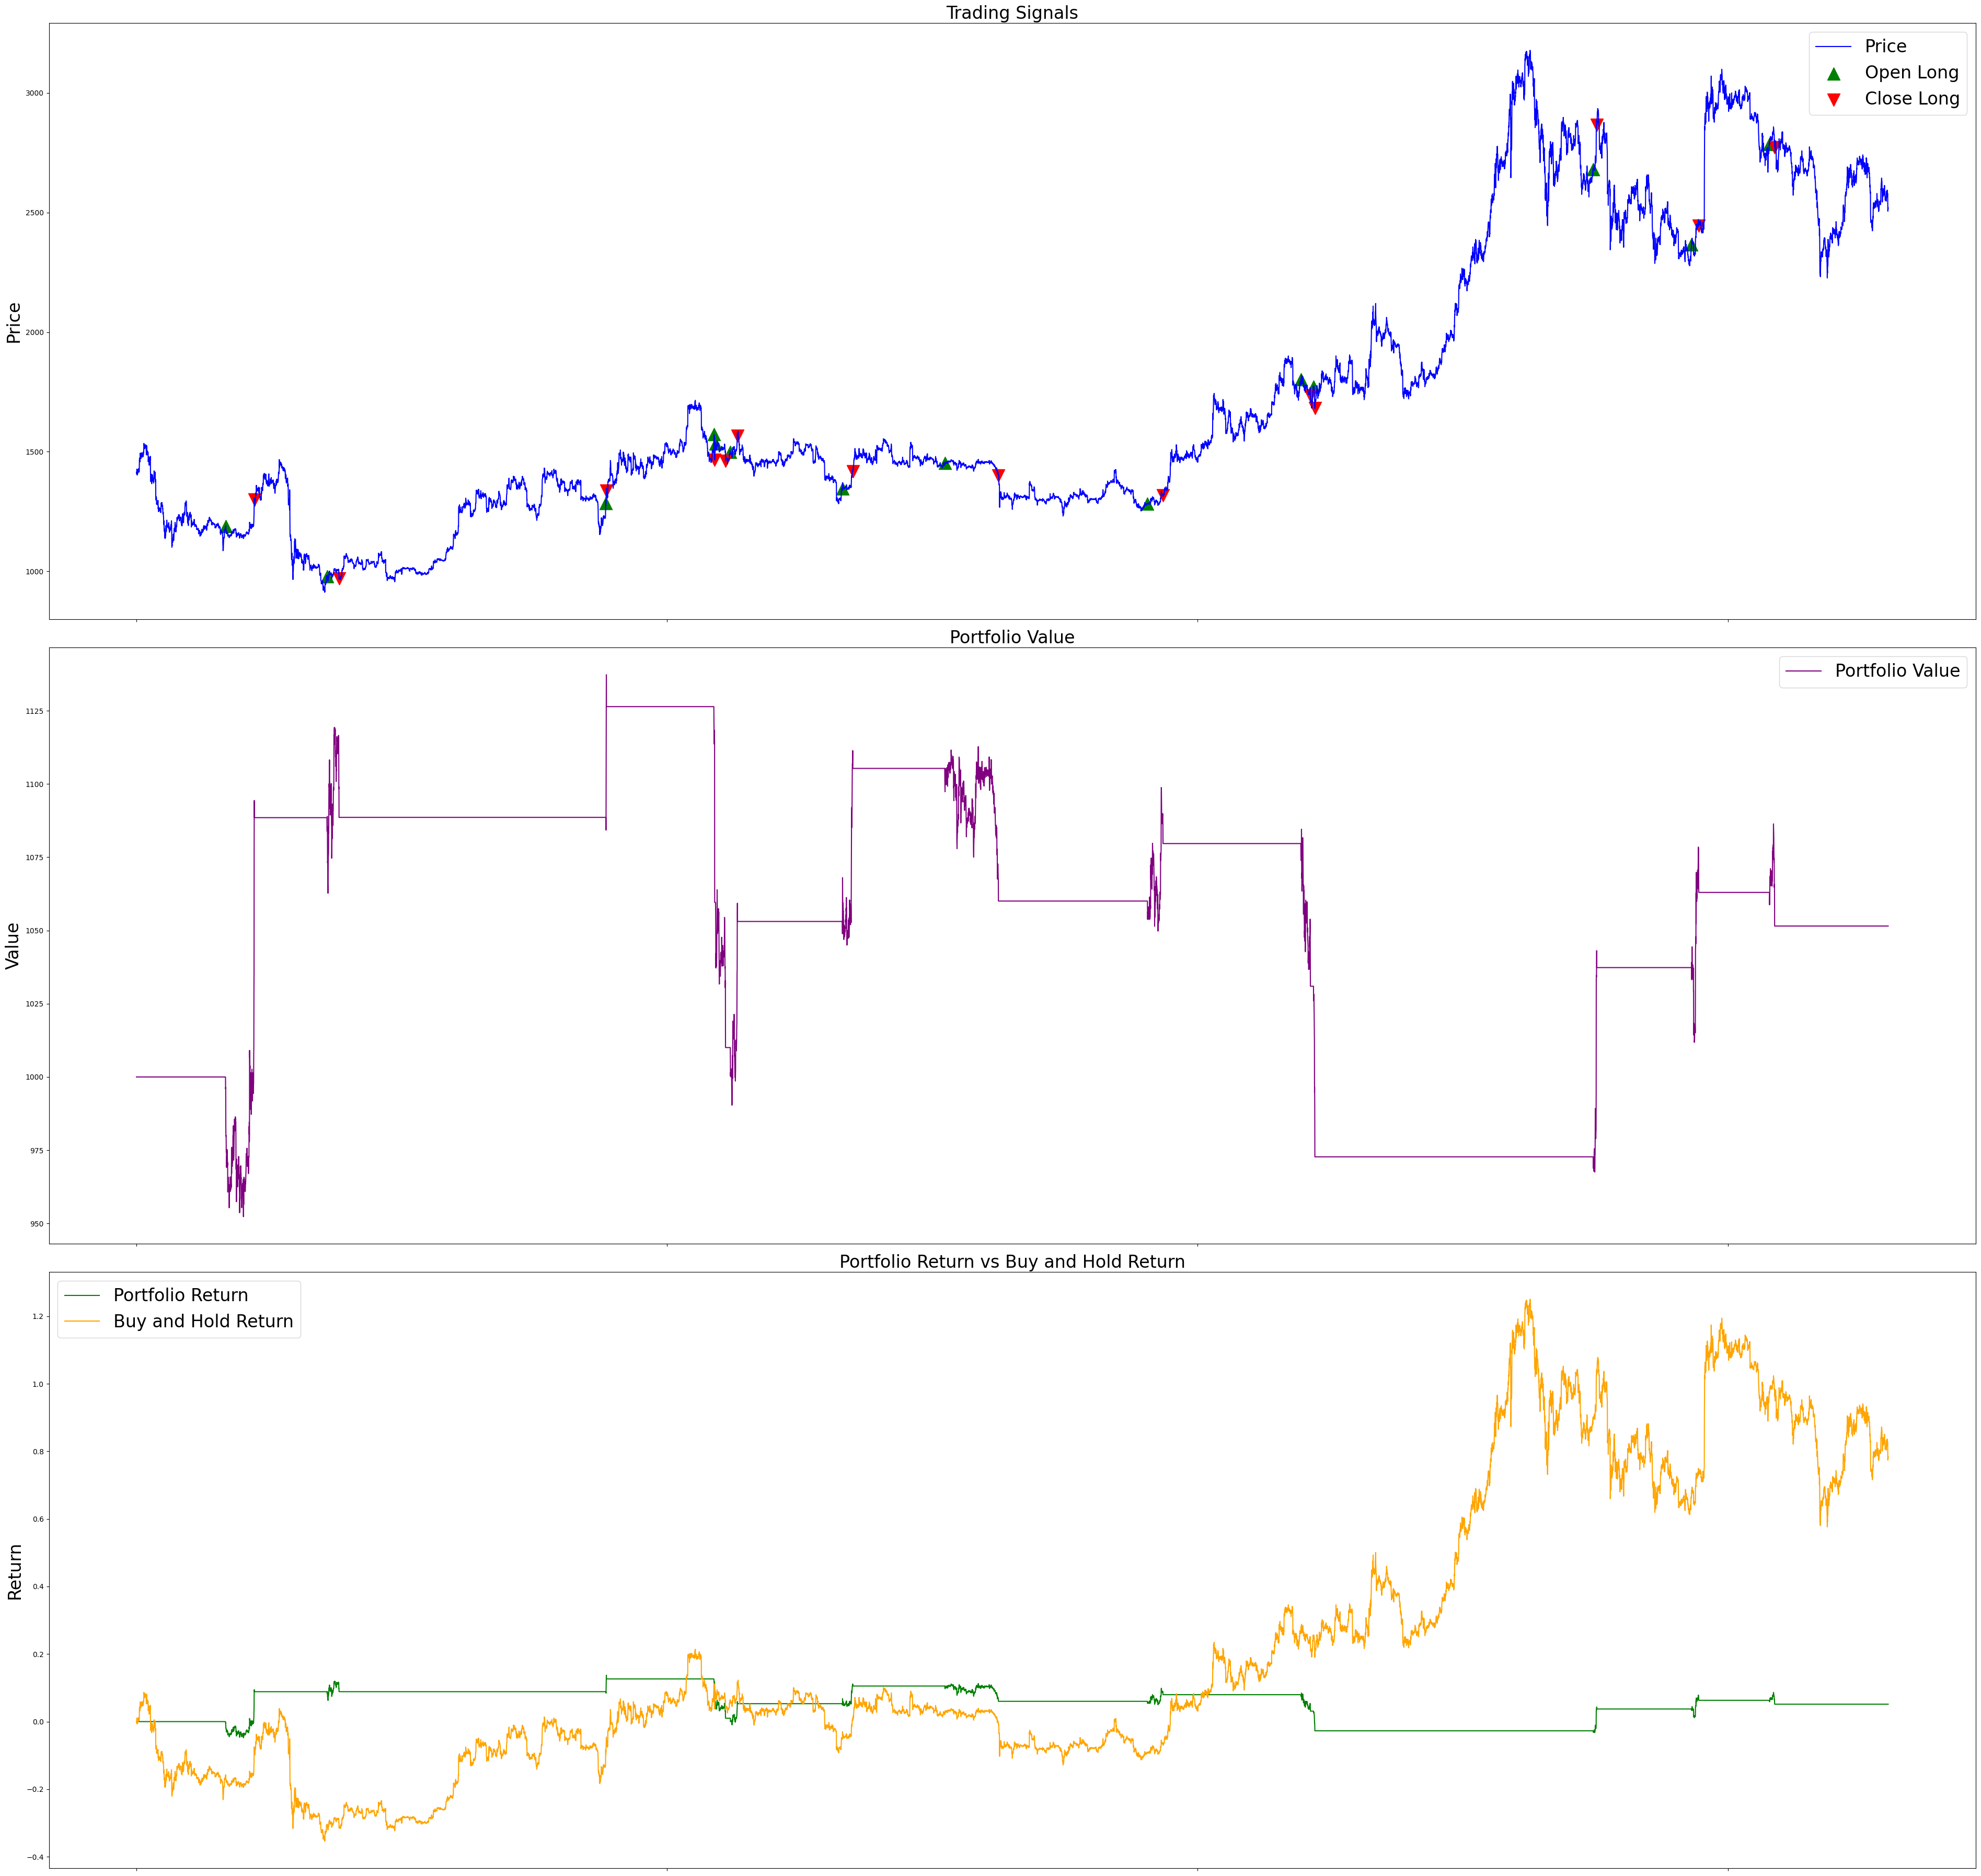

Request to open long position on ETH-GBP
    Opening long position for ETH-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for ETH-GBP at 0.0009602166488814039 with quantity 1037265.9140625, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for ETH-GBP at 0.0009602166488814039 with quantity 1037265.9140625, total cost £999.984 and transaction cost £3.984
        Bought 1037265.9140625 ETH-GBP at 0.0009602166488814039 on 15/12/2022 07:00
    Creating TRAILING_STOP SELL order for ETH-GBP at 0.0009602166488814039 with quantity 1037265.9140625, trail 0.05, limit None, stop None, take_profit None
    Updated trailing stop to 0.0009167074691052966
    Creating TRAILING_STOP SELL order for ETH-GBP at 0.0009647183015493668 with quantity 1037265.9140625, trail 0.049330589130573525, limit None, stop None, take_profit None
Updated trailing stop for ETH-GBP to 0.00 (trail: 4.93%)
    Updated trailing stop to 0.0009201999070976873
    Creating TR

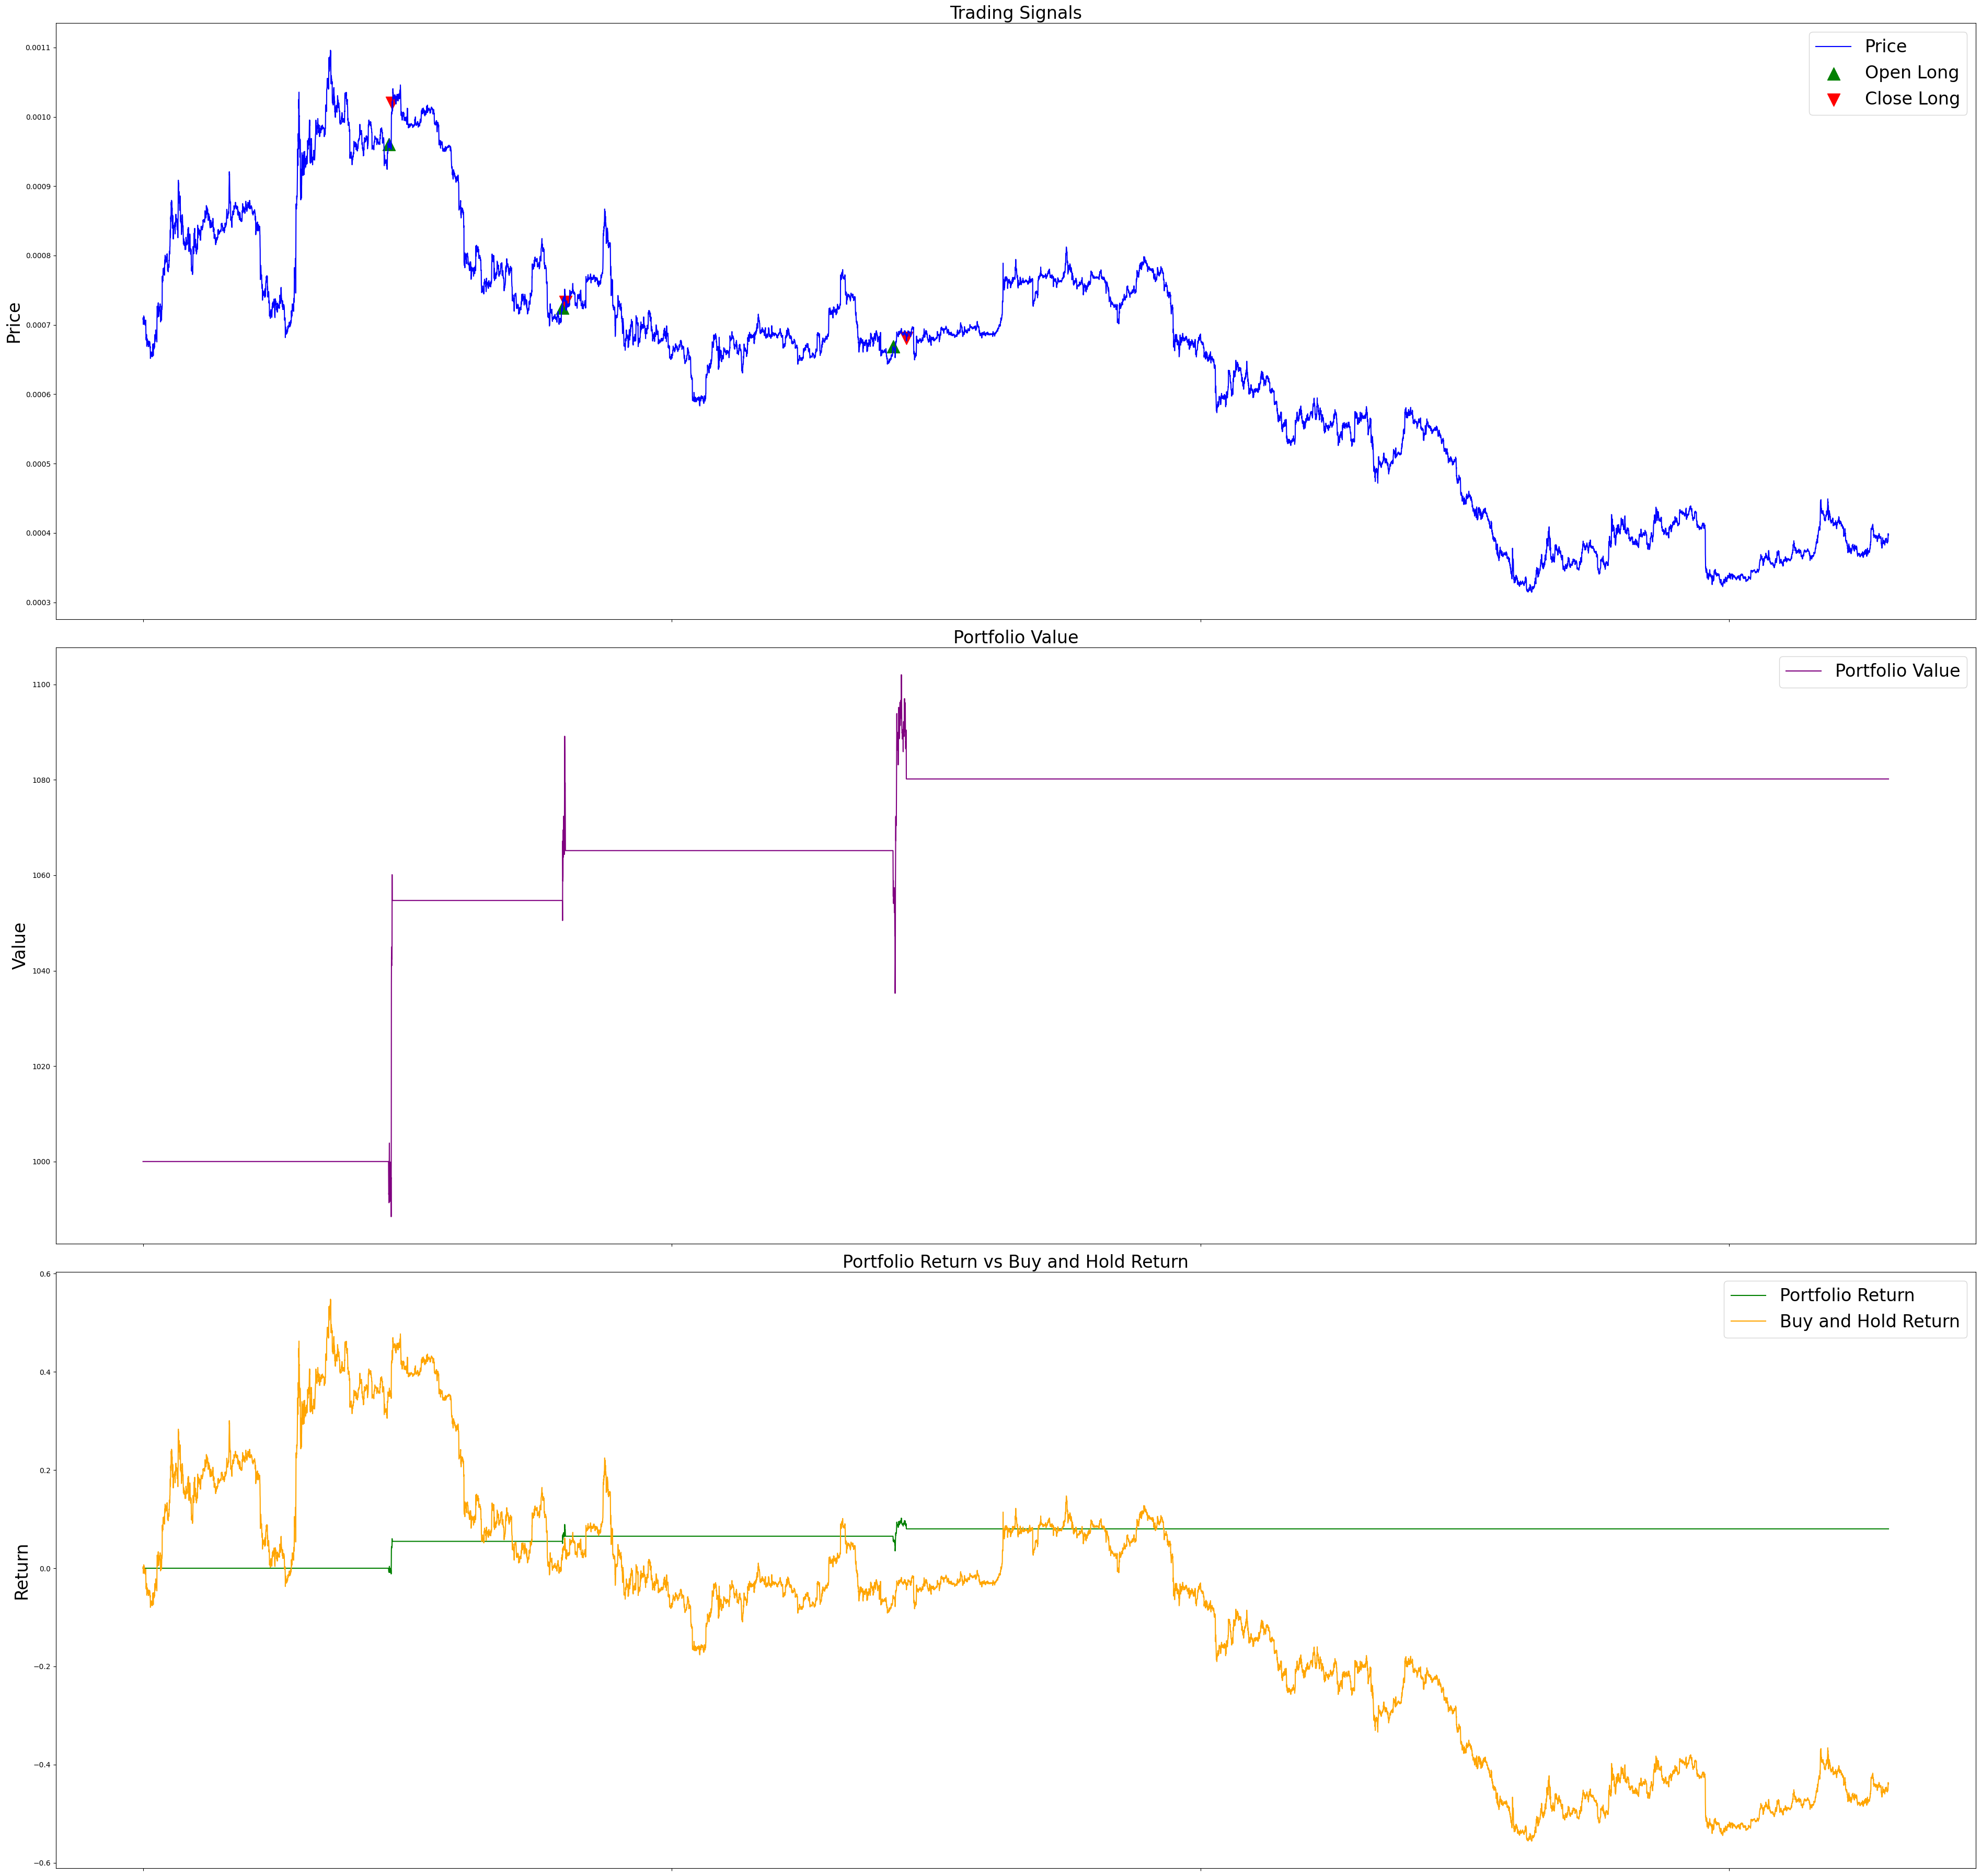

Request to open long position on SOL-GBP
    Opening long position for SOL-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for SOL-GBP at 25.81252098083496 with quantity 38.585925053174805, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for SOL-GBP at 25.81252098083496 with quantity 38.585925053174805, total cost £999.984 and transaction cost £3.984
        Bought 38.585925053174805 SOL-GBP at 25.81252098083496 on 23/10/2022 22:00
    Creating TRAILING_STOP SELL order for SOL-GBP at 25.81252098083496 with quantity 38.585925053174805, trail 0.05, limit None, stop None, take_profit None
    Updated trailing stop to 24.56512689590454
    Updated trailing stop to 25.905216693878174
    Creating TRAILING_STOP SELL order for SOL-GBP at 27.195842742919922 with quantity 38.585925053174805, trail 0.001, limit None, stop None, take_profit None
Updated trailing stop for SOL-GBP to 27.17 (trail: 0.10%)
    Updated trailing stop to 27.80753621

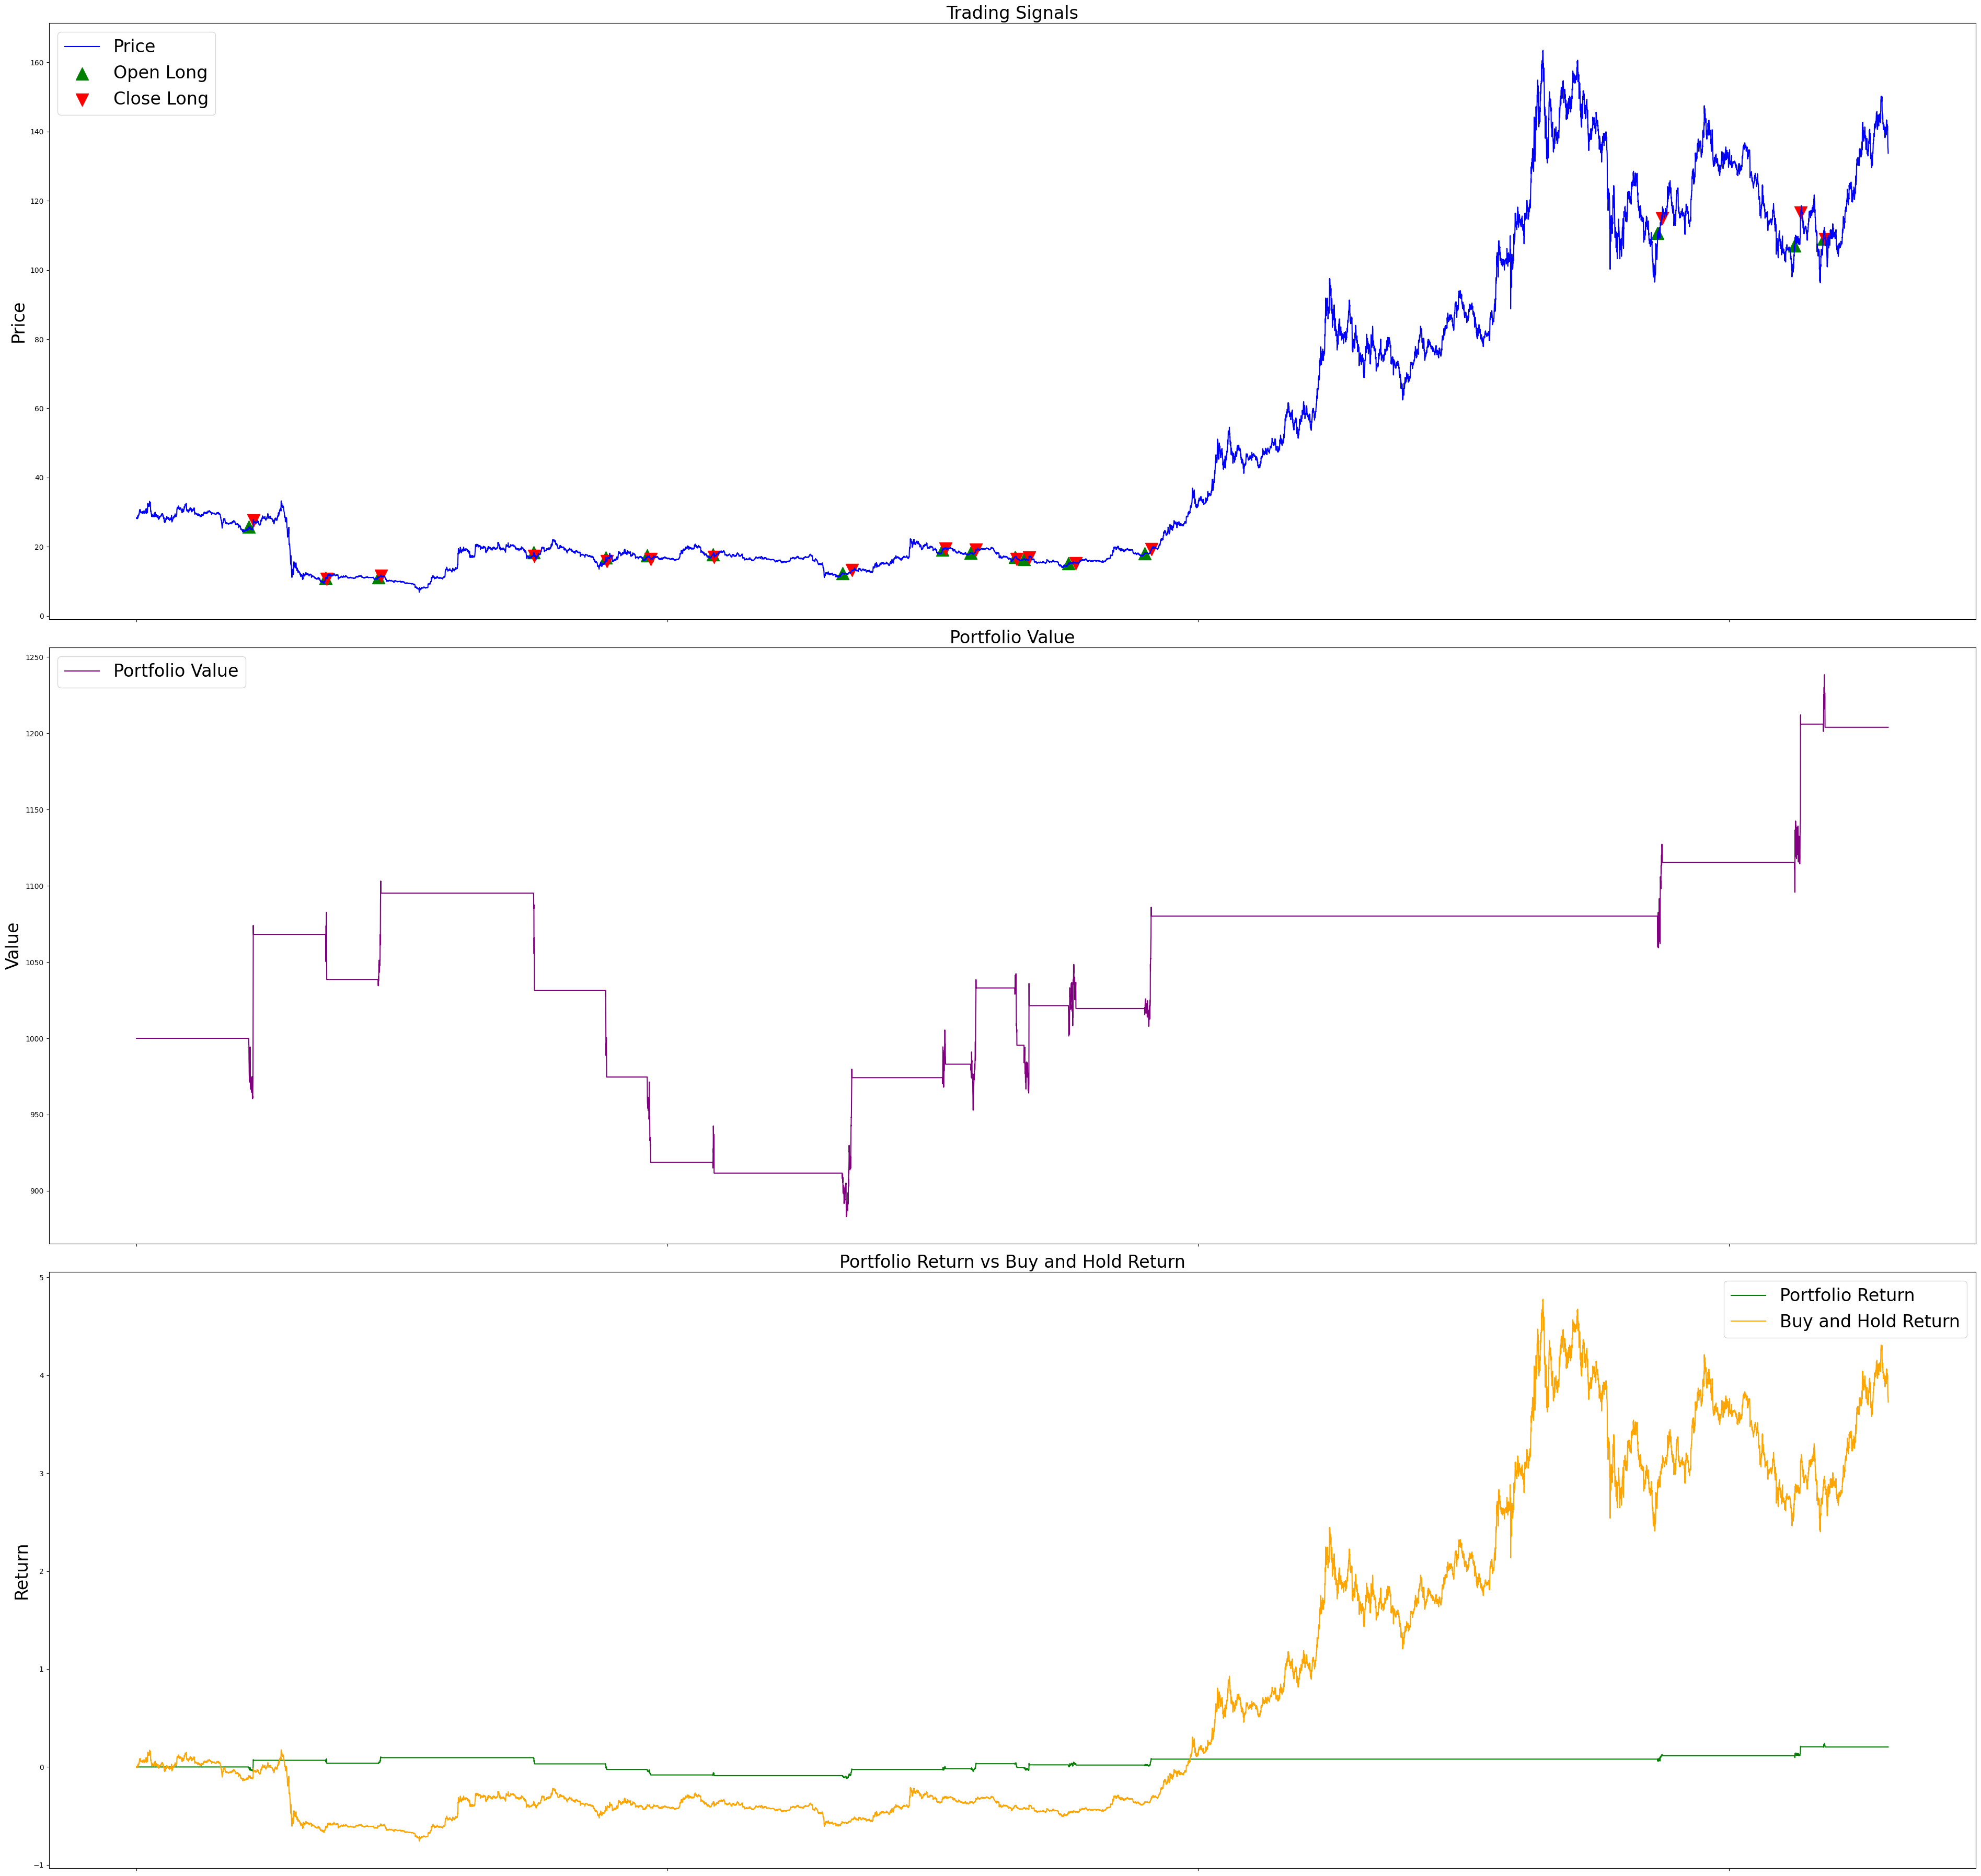

Request to open long position on SOL-GBP
    Opening long position for SOL-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for SOL-GBP at 0.033650794954845416 with quantity 29598.112060546875, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for SOL-GBP at 0.033650794954845416 with quantity 29598.112060546875, total cost £999.984 and transaction cost £3.984
        Bought 29598.112060546875 SOL-GBP at 0.033650794954845416 on 13/09/2022 20:00
    Creating TRAILING_STOP SELL order for SOL-GBP at 0.033650794954845416 with quantity 29598.112060546875, trail 0.05, limit None, stop None, take_profit None
    Updated trailing stop to 0.032291280307288416
    Creating TRAILING_STOP SELL order for SOL-GBP at 0.03397382005503068 with quantity 29598.112060546875, trail 0.044439066886347106, limit None, stop None, take_profit None
Updated trailing stop for SOL-GBP to 0.03 (trail: 4.44%)
    Updated trailing stop to 0.03280128227209812
    Creat

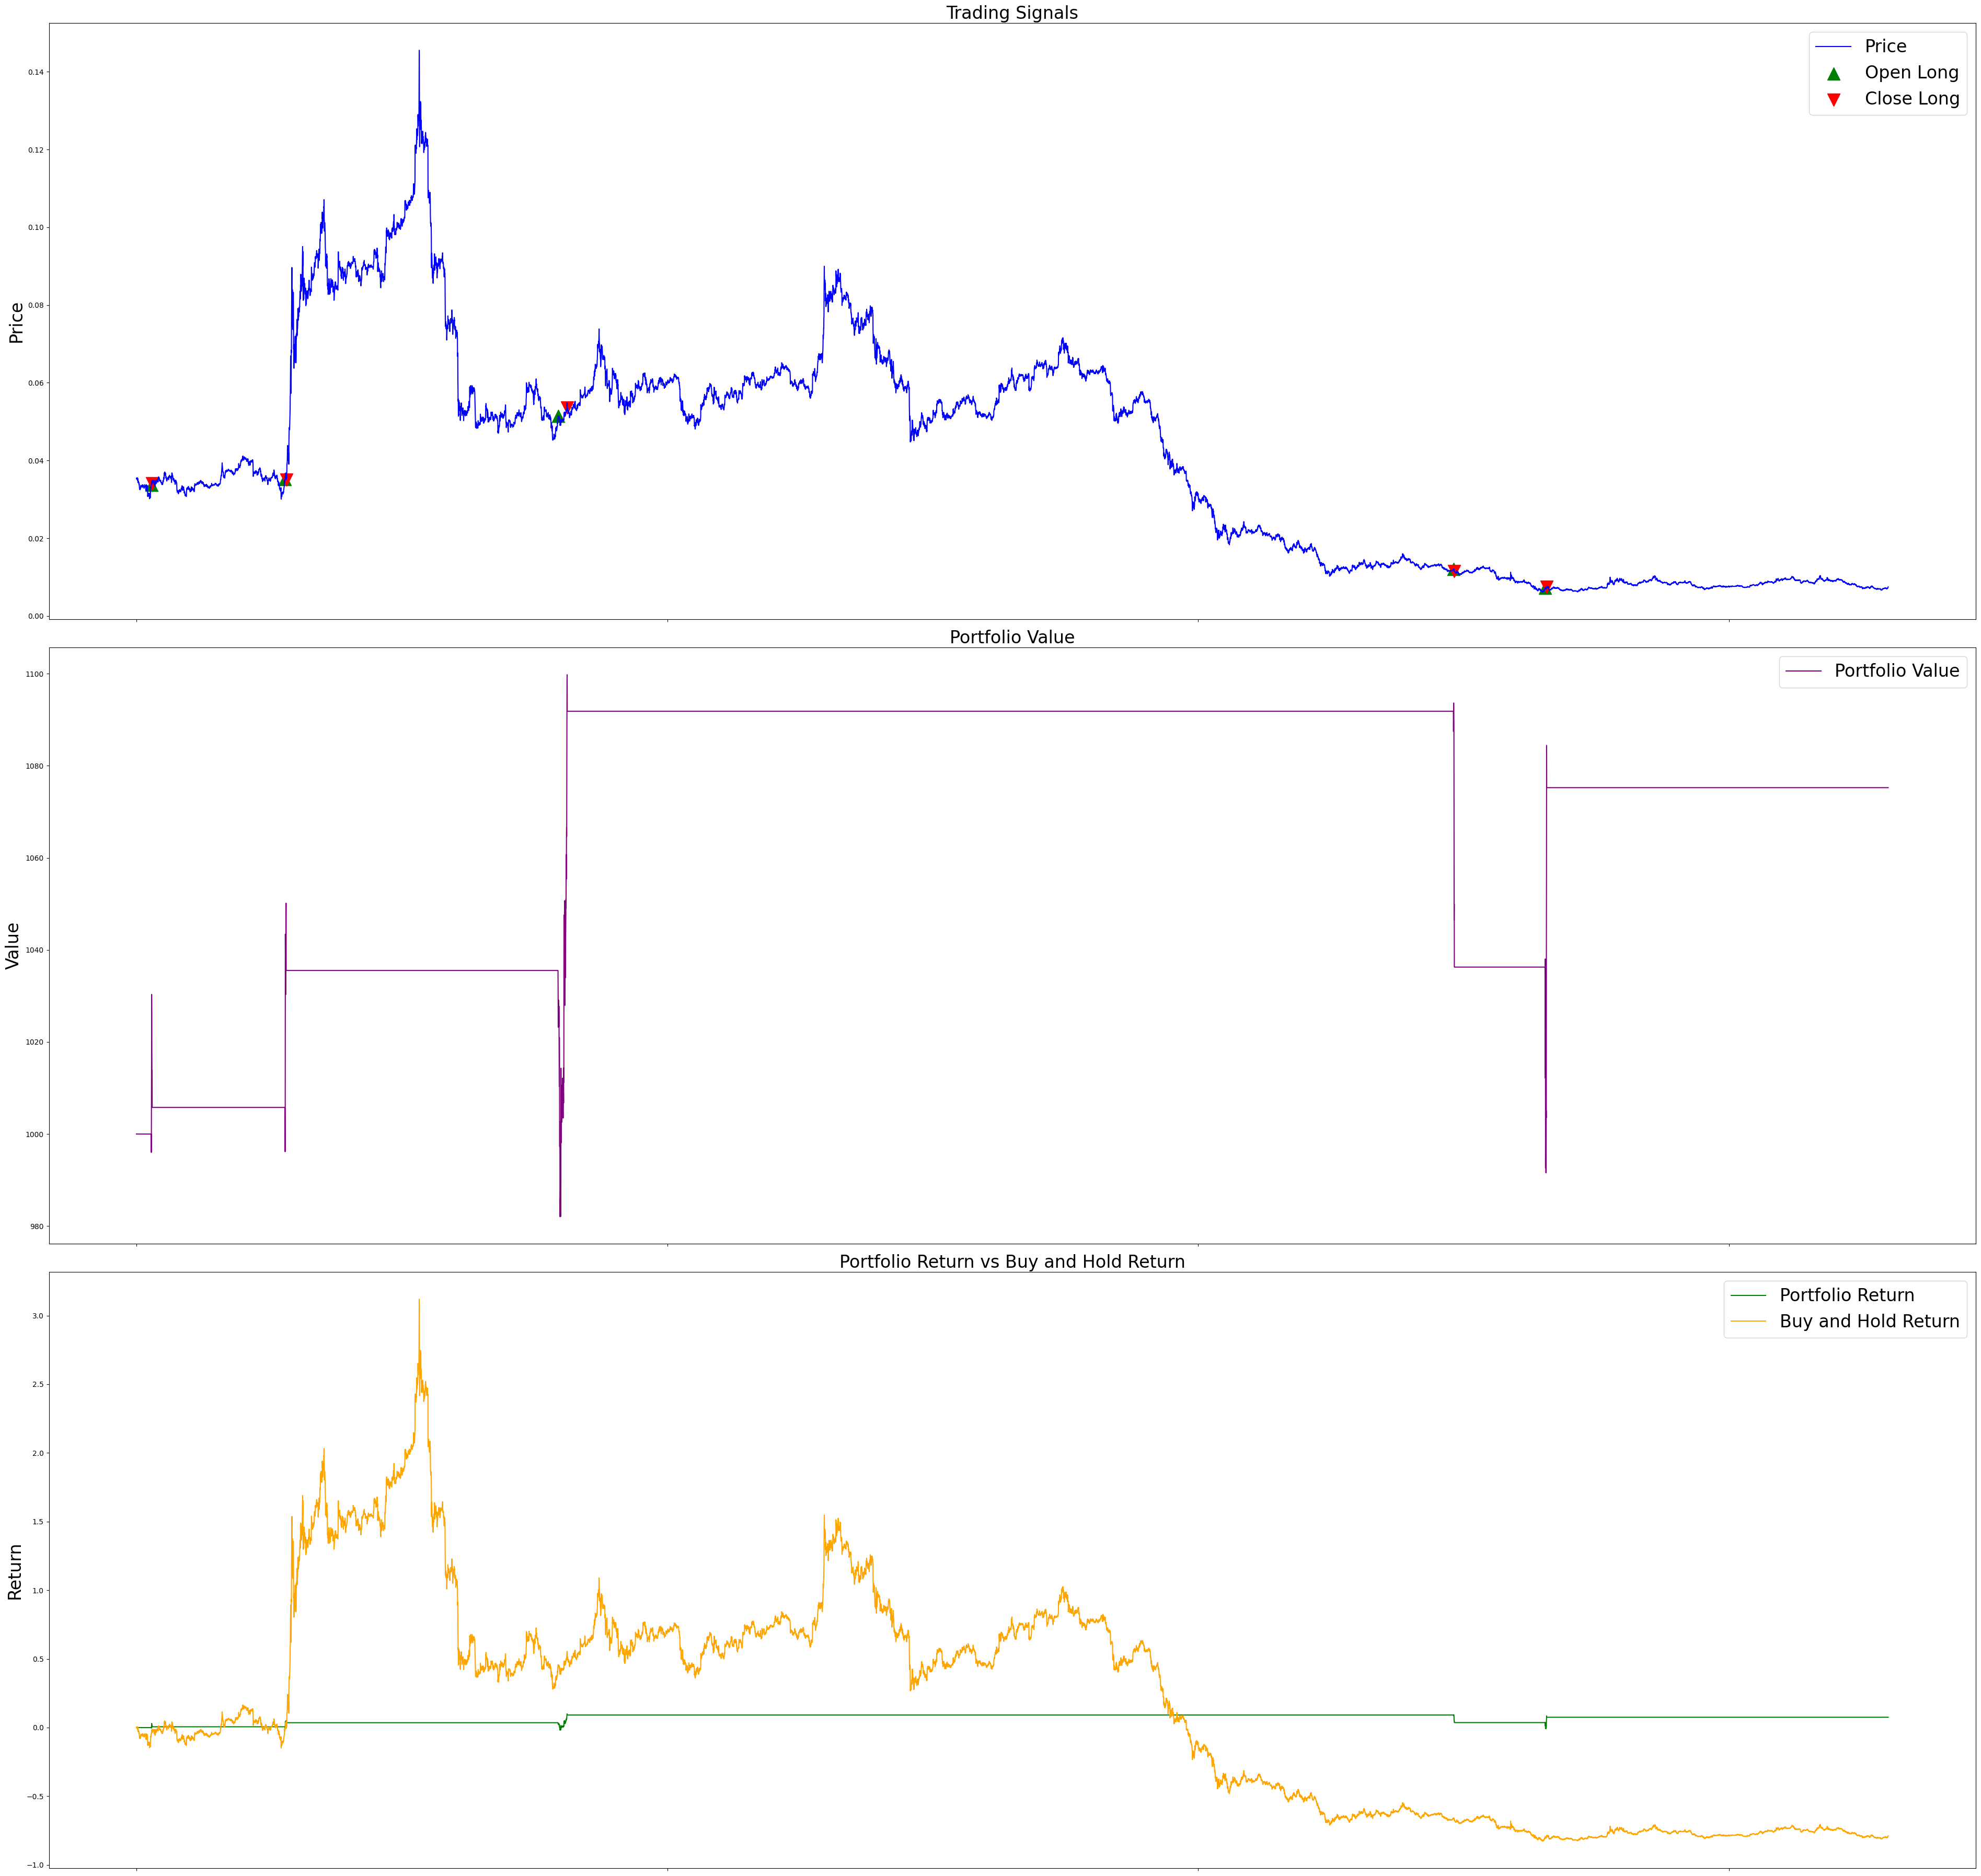

Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for BTC-GBP at 17376.3125 with quantity 0.057319411123620156, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for BTC-GBP at 17376.3125 with quantity 0.057319411123620156, total cost £999.984 and transaction cost £3.984
        Bought 0.057319411123620156 BTC-GBP at 17376.3125 on 14/10/2022 07:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 17376.3125 with quantity 0.057319411123620156, trail 0.05, limit None, stop None, take_profit None
    Updated trailing stop to 16519.905078125
    Updated trailing stop to 16610.5125
    Creating TRAILING_STOP SELL order for BTC-GBP at 17479.328125 with quantity 0.057319411123620156, trail 0.04809520503846829, limit None, stop None, take_profit None
Updated trailing stop for BTC-GBP to 16638.66 (trail: 4.81%)
    Updated trailing stop to 16678.43945801846
    Creati

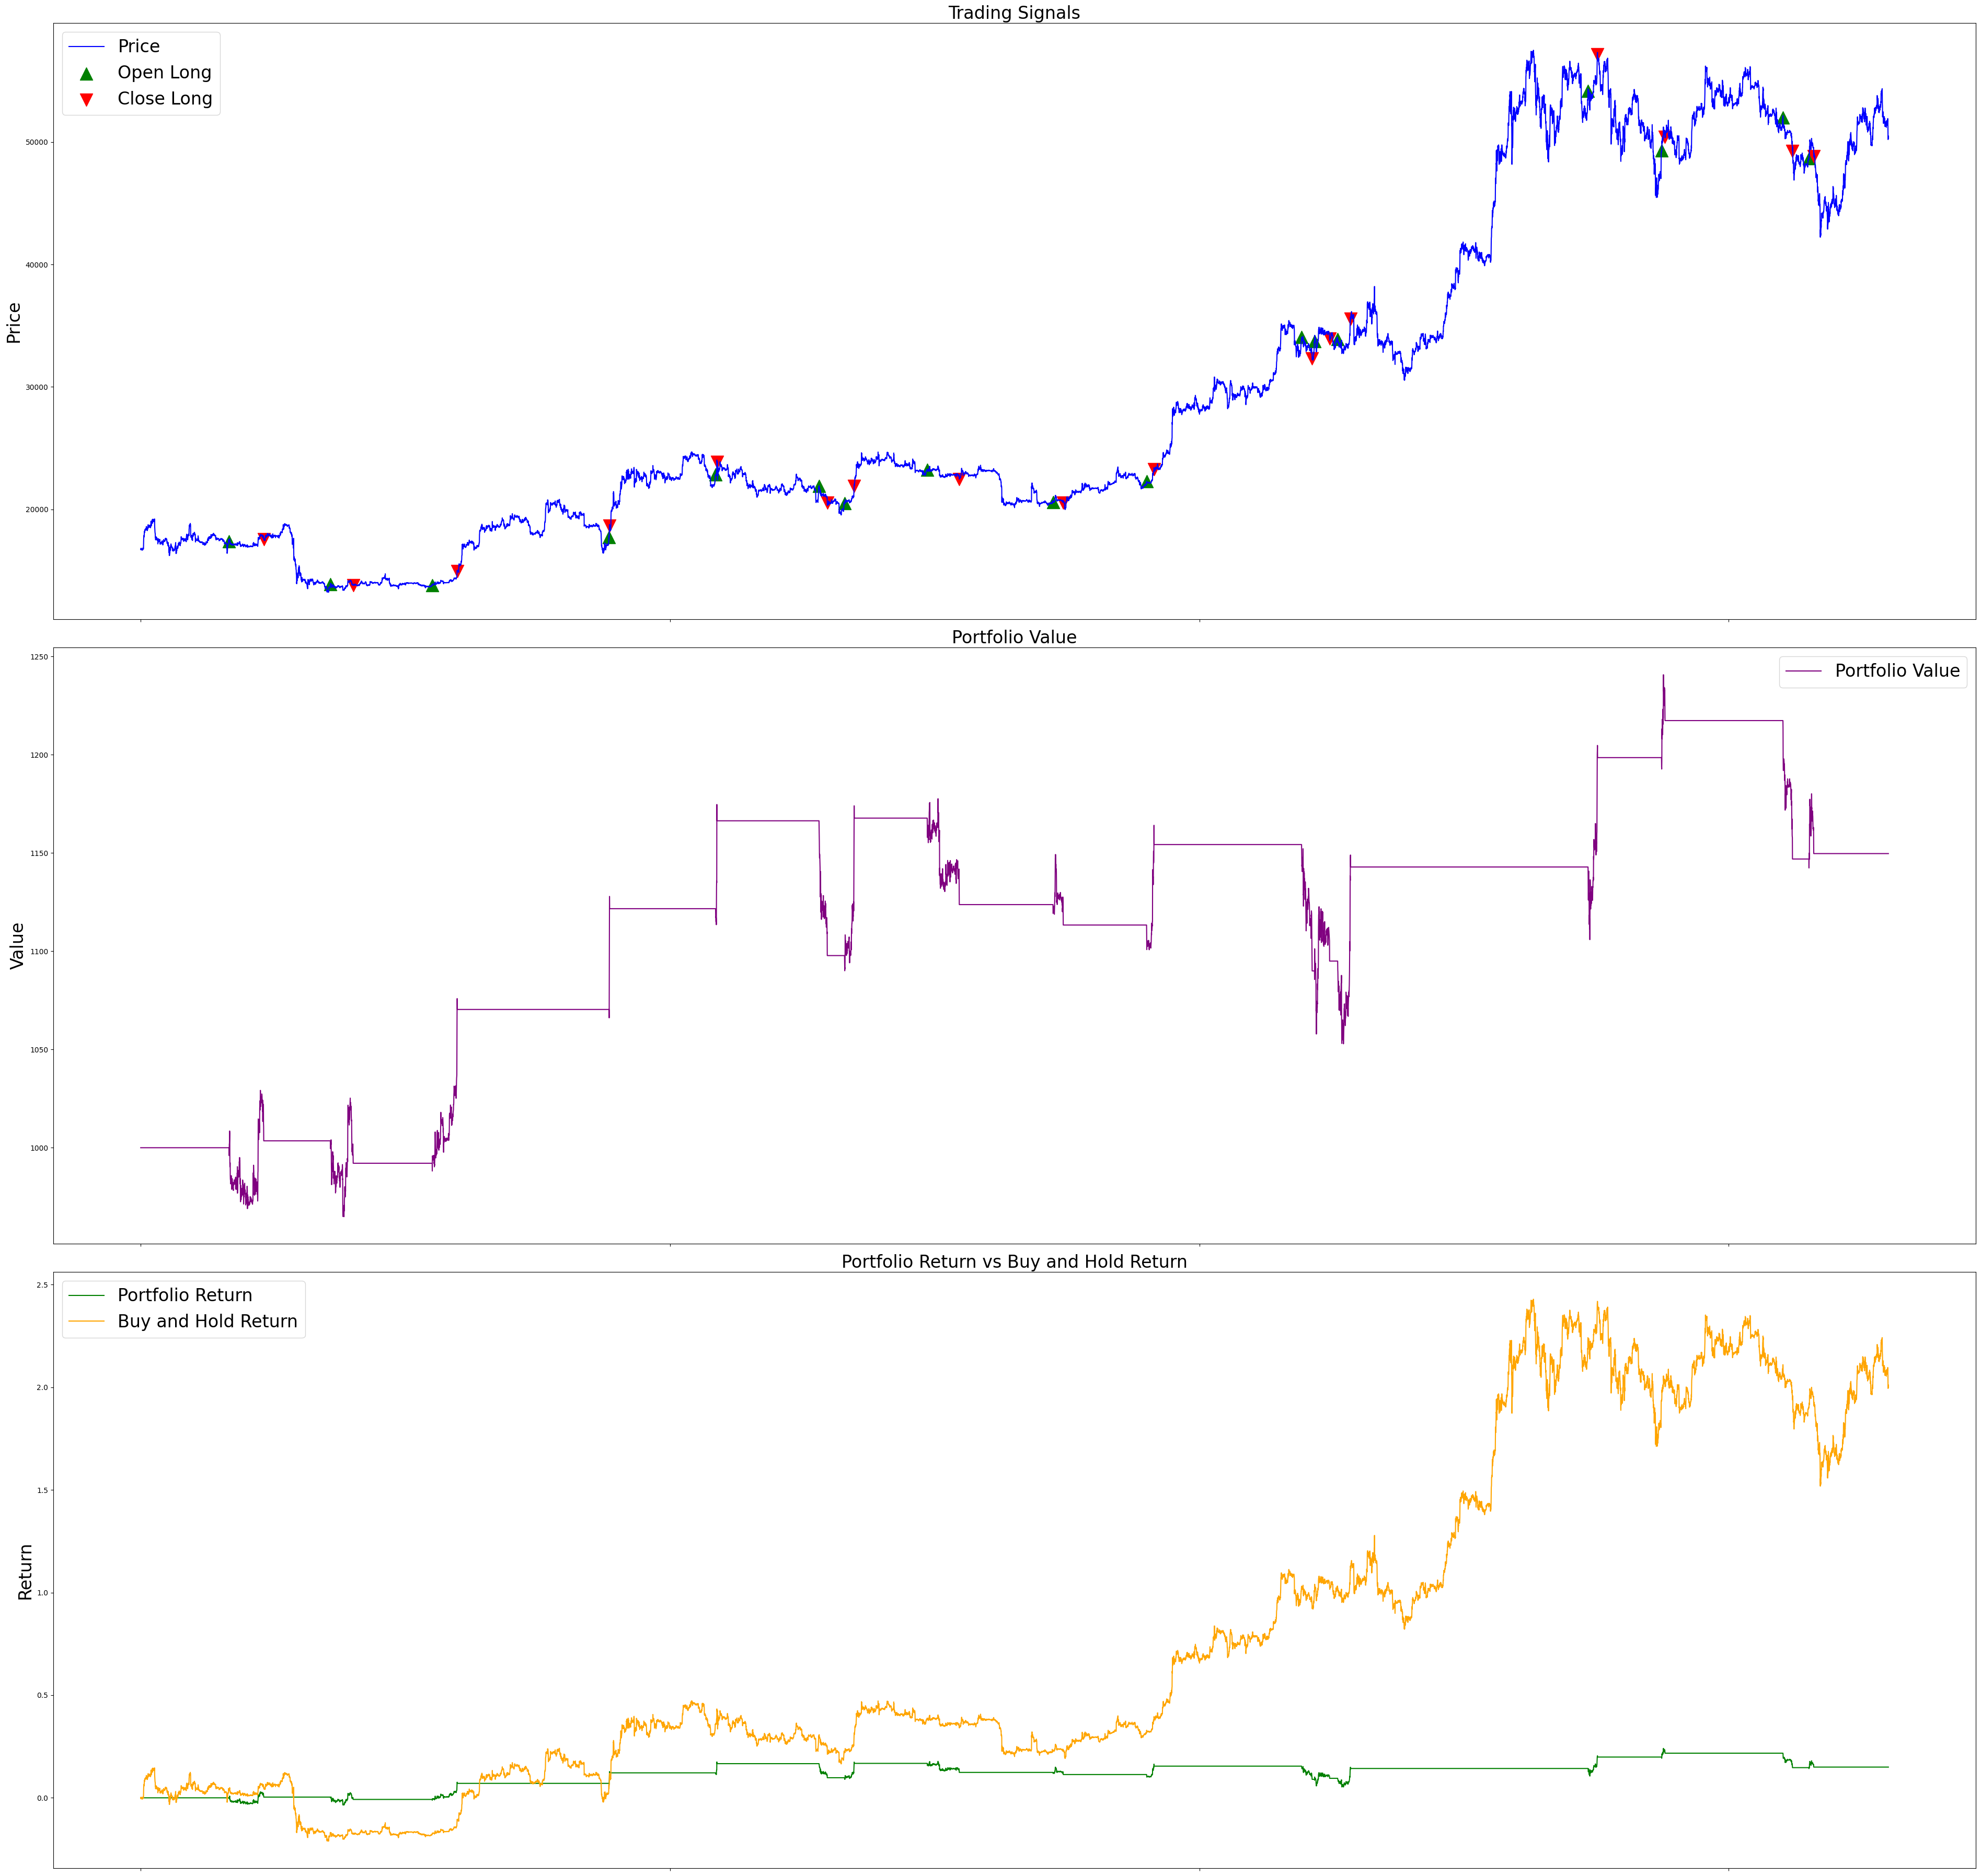

Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for BTC-GBP at 5.543642978997822e-05 with quantity 17966524.96875, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for BTC-GBP at 5.543642978997822e-05 with quantity 17966524.96875, total cost £999.984 and transaction cost £3.984
        Bought 17966524.96875 BTC-GBP at 5.543642978997822e-05 on 13/09/2022 17:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 5.543642978997822e-05 with quantity 17966524.96875, trail 0.05, limit None, stop None, take_profit None
    Updated trailing stop to 5.3637351258965316e-05
    Creating TRAILING_STOP SELL order for BTC-GBP at 5.640917274846423e-05 with quantity 17966524.96875, trail 0.03652318934818539, limit None, stop None, take_profit None
Updated trailing stop for BTC-GBP to 0.00 (trail: 3.65%)
    Updated trailing stop to 5.448869264081248e-05
    Creating TRAILIN

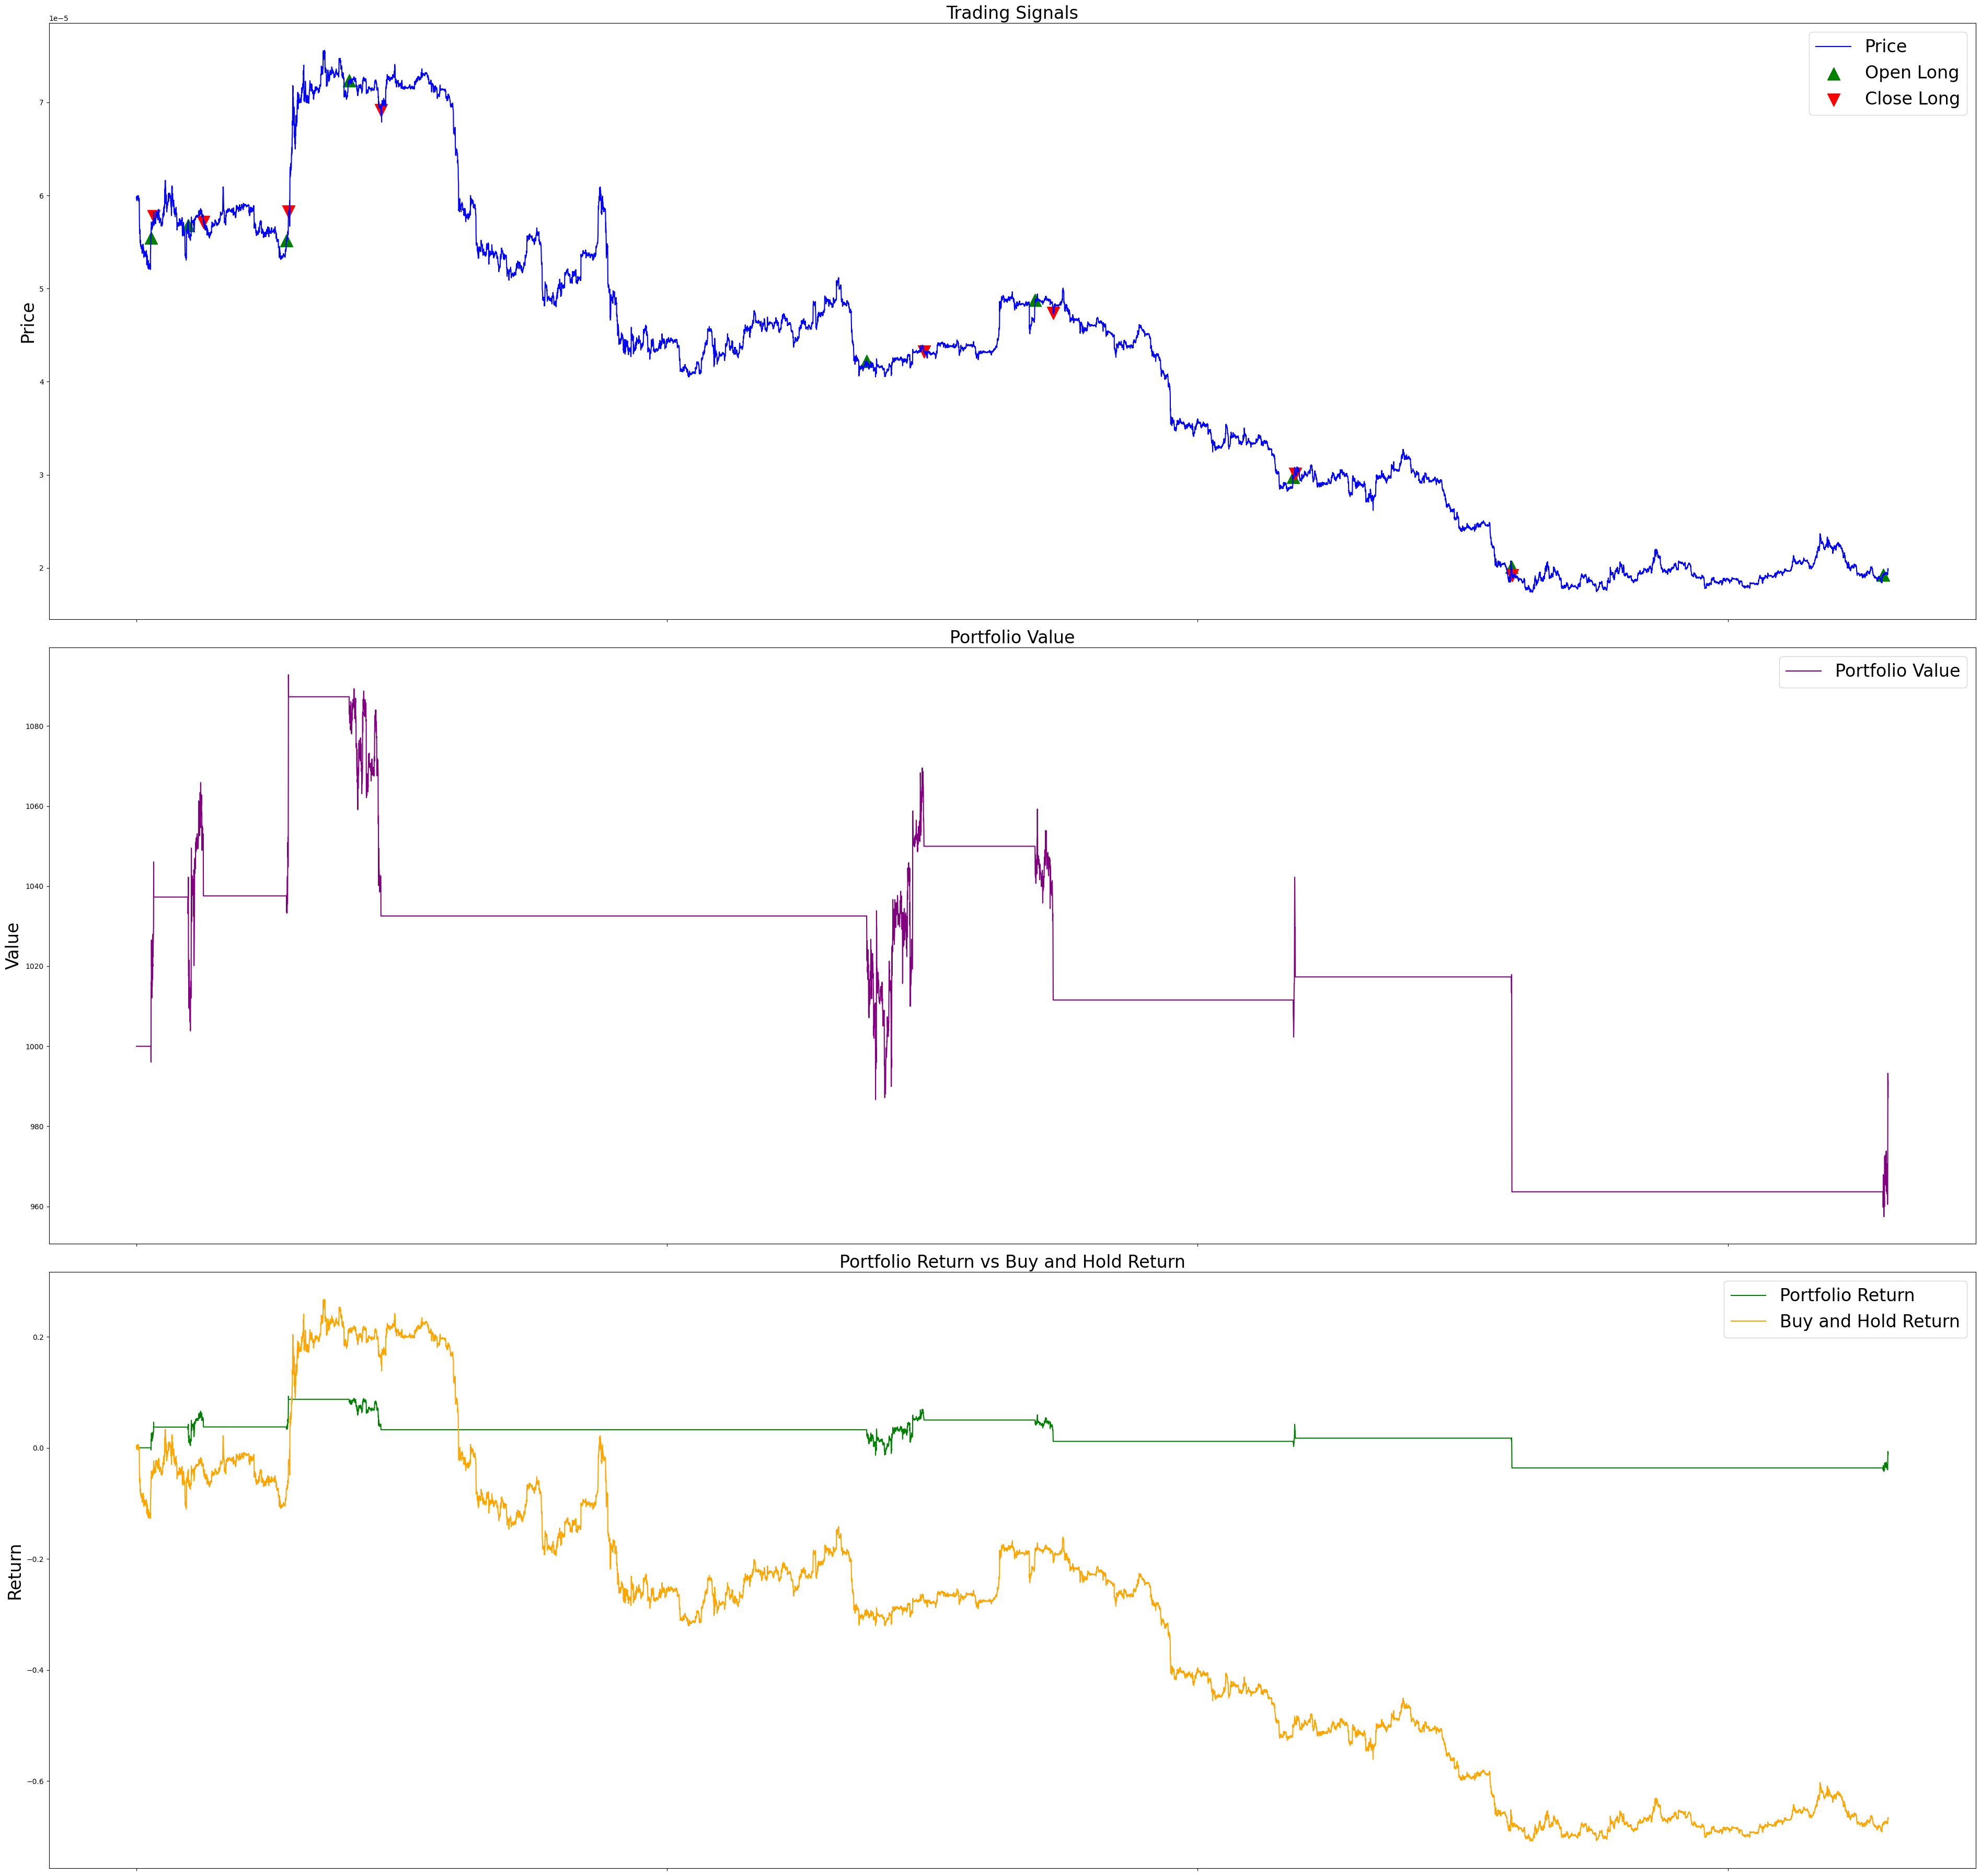

Average win rate: 0.7150910364145657
Average return: 0.09197863524250355


In [9]:
from datetime import datetime

test_symbols=[
    {'symbol':'ETH-GBP', 'reverse_pair':False},
    {'symbol':'ETH-GBP', 'reverse_pair':True},
    {'symbol':'SOL-GBP', 'reverse_pair':False},
    {'symbol':'SOL-GBP', 'reverse_pair':True},
    {'symbol':'BTC-GBP', 'reverse_pair':False},
    {'symbol':'BTC-GBP', 'reverse_pair':True}
]

train_since = pd.to_datetime('2022-09-01').tz_localize('UTC')
start_date = pd.to_datetime('2022-09-08').tz_localize('UTC')
end_date = pd.to_datetime('2024-08-01').tz_localize('UTC')
period = 168
frequency = '1h'

strategy_params = {
    'trail_percentage': 0.05,
    'take_profit_percentage': 0.05,
    
    #'cci_length': 48,
    #'cci_threshold': 0,
    #'adx_length': 24,
    #'adx_threshold': 20,
    #'sma_length_short': 12,
    #'sma_length_long': 72,

    'rsi_length': 48,
    'rsi_oversold': 25,
    'ema_length_very_short': 6,
    'ema_length_short': 18,
    'ema_length_long': 72,
    'adx_length': 18,
    'adx_threshold': 25,
    #'v_width': 12,

    #'adx_length': 12,
    #'adx_threshold': 40,
    #'ema_length_short': 6,
    #'ema_length_long': 96,

    #'sma_length_long': 84,
    #'drop_period': 12,
    #'recovery_period': 6,
    #'drop_threshold': 2,
    #'recovery_threshold': 2,
    #'rsi_length': 6,
    #'rsi_not_overbought': 60,
}

#strategy = AdxSmaCciStrategy(strategy_params)
strategy = AdxEmaRsiStrategy(strategy_params)
#strategy = AdxEmaStrategy(strategy_params)
#strategy = SmaBuyDipStrategy(strategy_params)

win_rates = 0
returns = 0

for symbol in test_symbols:
    feed = YFinanceFeed(interval = frequency, invert_pair = symbol['reverse_pair'])
    trader = Trader(symbol['symbol'], 1000, feed, strategy)
    portfolio = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)
    perf = portfolio.plot_performance()
    write_to_csv(strategy, symbol['symbol'], symbol['reverse_pair'], start_date, end_date, frequency, strategy_params, perf, portfolio)

    win_rates += perf['win_rate']
    returns += perf['portfolio_return']

print(f"Average win rate: {win_rates / len(test_symbols)}")
print(f"Average return: {returns / len(test_symbols)}")
